In [1]:

# dataset from https://www.kaggle.com/datasets/kasikrit/att-database-of-faces?resource=download
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
from keras import layers
#import keras one hot encoder
from keras.utils import to_categorical

directory="dataset"



def loadImages(folder, y):
    images = []
    labels = []
    pics = os.listdir(folder)
    for pic in pics:
        img = cv2.imread(os.path.join(folder,pic))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # transform to grayscale
        if img is not None:
            images.append(img)
            labels.append(y)
    return images, labels


def load_images_from_folder(folder):
    images = []
    labels = []
    dirs = os.listdir(folder)
    dirs.remove("README")
    for directory in dirs:
        y = directory[1:]
        path = os.path.join(folder, directory)
        i, l = loadImages(path, y)
        images = images + i 
        labels = labels + l
    images = np.array(images) 
    images = images.reshape(images.shape[0],images.shape[1] * images.shape[2])
    labels = np.array(labels)
    return images, labels

images, labels = load_images_from_folder(directory)
#reshape images
# images = images.reshape(images.shape[0], 112, 92, 1)
# images=np.expand_dims(images, axis=2)
images=images.astype('float32')
#normalize images
# images /= 255
labels=to_categorical(labels)
#shuffle data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]


#split data
train_images = images[:int(images.shape[0]*0.8)]
train_labels = labels[:int(labels.shape[0]*0.8)]
test_images = images[int(images.shape[0]*0.8):]
test_labels = labels[int(labels.shape[0]*0.8):]



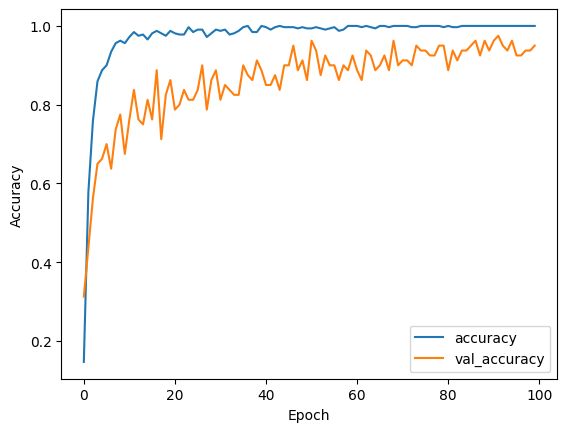

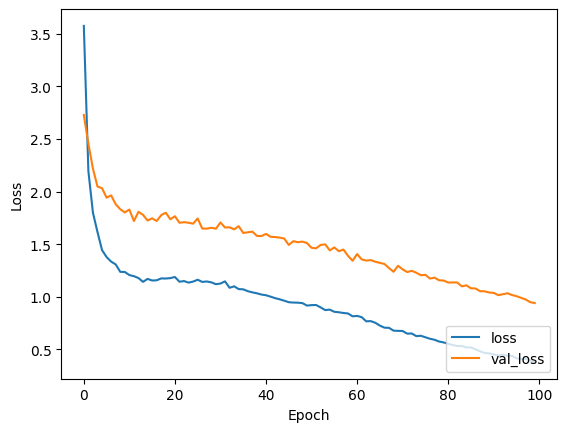

In [2]:
IMAGE_SIZE=224


model = tf.keras.Sequential([
        layers.Normalization(),
        tf.keras.layers.Dense(10304*2, activation = 'tanh'),
        tf.keras.layers.Dense(labels.shape[1], 'softmax')
    ],
    name = 'MLP')


model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])


history=model.fit(
    train_images,train_labels,
        epochs=100,
        batch_size=8*4,
        validation_data=(test_images, test_labels),
        verbose=0
        )
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')


plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 1])
plt.legend(loc='lower right')


Lasso Model Fitting

In [3]:
from sklearn.linear_model import Lasso

input_fodder=train_images

# Generate predictions for a set of input
predictions = model.predict(input_fodder)

# Use Lasso regression to perform compressed sensing on the model's output
lasso = Lasso(alpha=0.01)
lasso.fit(predictions, input_fodder)

10/10 [==============================] - 0s 4ms/step


Lasso(alpha=0.01)

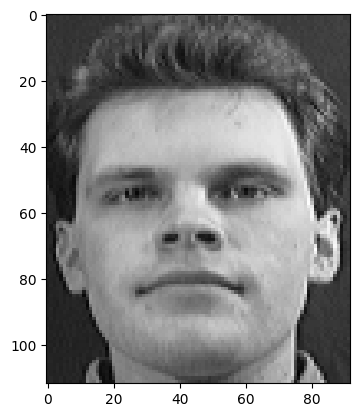

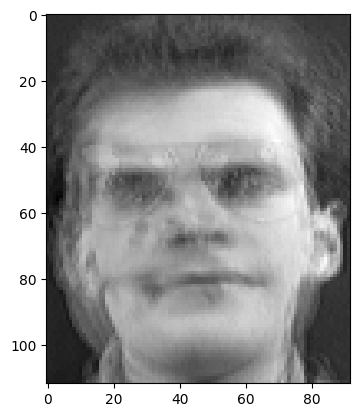

In [4]:
# Use the trained Lasso model to reconstruct the original input
checker_label=test_labels[0:1]
reconstructed_input = lasso.predict(checker_label)
checker_reference=test_images[0:1]

reference_image=checker_reference.reshape(checker_reference.shape[0], 112, 92, 1)
predicted_image=reconstructed_input.reshape(reconstructed_input.shape[0], 112, 92, 1)

plt.figure()
plt.imshow(reference_image[0,:,:,0], cmap='gray')

plt.figure()
plt.imshow(predicted_image[0,:,:,0]*255, cmap='gray')

Lasso Model Fitting (New Strategy)

10/10 [==============================] - 0s 31ms/step


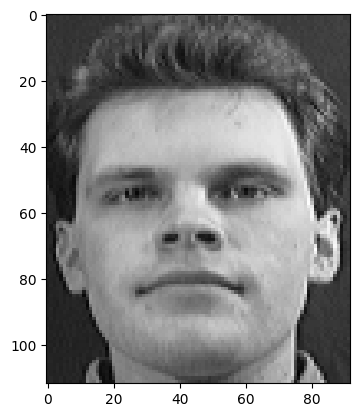

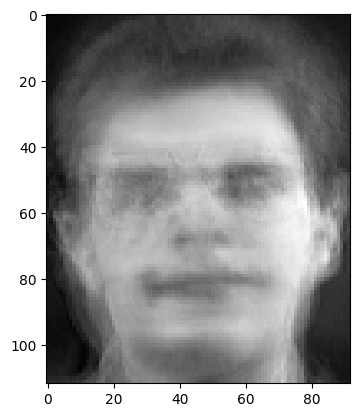

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


input_fodder=train_images

# Generate predictions for a set of input
predictions = model.predict(input_fodder)


# Use principal component analysis (PCA) to reduce the dimensionality of the output
pca = PCA(n_components=25)
pca.fit(predictions)

# Use the PCA model to transform the predictions into a lower-dimensional space
transformed_predictions = pca.transform(predictions)

# Use Lasso regression to perform compressed sensing on the transformed predictions
lasso = Lasso(alpha=0.01)

# Scale the inputs and transformed predictions for improved accuracy
scaler = StandardScaler()
scaled_input_fodder= scaler.fit_transform(input_fodder)
scaler2 = StandardScaler()
scaled_predictions = scaler2.fit_transform(transformed_predictions)

# Fit the Lasso model to the scaled inputs and transformed predictions
lasso.fit(scaled_predictions, scaled_input_fodder)


# Use the trained Lasso model to reconstruct the original input
checker_label=test_labels[0:1]
sub_checker_label=pca.transform(checker_label)
transformed_checker_label=scaler2.transform(sub_checker_label)
reconstructed_input = lasso.predict(transformed_checker_label)
checker_reference=test_images[0:1]

# Invert the scaling transformation to get the reconstructed input in the original scale
reconstructed_input = scaler.inverse_transform(reconstructed_input)



reference_image=checker_reference.reshape(checker_reference.shape[0], 112, 92, 1)
predicted_image=reconstructed_input.reshape(reconstructed_input.shape[0], 112, 92, 1)

plt.figure()
plt.imshow(reference_image[0,:,:,0], cmap='gray')

plt.figure()
plt.imshow(predicted_image[0,:,:,0]*255, cmap='gray')
